In [7]:
!gdown --id 1o7B8XJ33OjCo8paZytvvVsxncm9wvVke

Downloading...
From: https://drive.google.com/uc?id=1o7B8XJ33OjCo8paZytvvVsxncm9wvVke
To: /content/BigData_Homework1_Data.zip
377MB [00:03, 125MB/s]


In [8]:
!unzip BigData_Homework1_Data.zip

Archive:  BigData_Homework1_Data.zip
   creating: Data/
   creating: Data/question 2_Association rules' application/
  inflating: Data/question 2_Association rules' application/browsing.txt  
   creating: Data/question 3_LSH/
   creating: Data/question 3_LSH/data/
  inflating: Data/question 3_LSH/data/patches.csv  
  inflating: Data/question 3_LSH/lsh.py  
   creating: Data/question 4_Data streams/
  inflating: Data/question 4_Data streams/counts.txt  
  inflating: Data/question 4_Data streams/counts_tiny.txt  
  inflating: Data/question 4_Data streams/hash_params.txt  
  inflating: Data/question 4_Data streams/words_stream.txt  
  inflating: Data/question 4_Data streams/words_stream_tiny.txt  


In [10]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
from timeit import default_timer
import matplotlib.pylab as plt
from matplotlib import style
style.use('ggplot')
# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
    w = 0
    for i in range(len(v)):
        w += abs(float(u[i]) - float(v[i]))
    return w

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    s =lambda v: sum([t[1] for t in v])

    return [t[0] for t in best_neighbors],[s(best_neighbors)]


# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):

    # Extract Query Vector
    query_vect = A[query_index]

    # Compute Distance to Each
    distances = []
    for index,row in enumerate(A):

        # don't include the query
        if index == query_index:
            continue

        # Extract the relevant data from the row
        distance = l1(query_vect, row)

        # This elimination step only works once we found n candidates
        if len(distances) >= num_neighbors:
            # Don't bother adding if it's farther than all "current best" neighbors
            if distance > distances[-1][1]:
                continue

        # Insert in sorted order to optimize
        idx = 0
        for i in range(len(distances)):
            if distances[i][1] > distance:
                idx = i
                break
        distances = distances[: idx] + [[index, distance]] + distances[idx: num_neighbors - 1]
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    s =lambda v: sum([t[1] for t in v])

    return [t[0] for t in best_neighbors],[s(best_neighbors)]


# TODO: Write a function that computes the error measure
def lsh_error(lsh_dist, linear_dist):
    error = 0
    for i in range(len(lsh_neighbors)):  # assume same number of searches run for both
        numerator = lsh_dist[i]
        denominator = linear_dist[i]
        print(numerator)
        print(denominator)
        error += numerator[0] / denominator[0]
    return error / 10

def plot(A,neighbor_list, base_filename, mark_closest=False):
    label = '[PLOT]'


    # Iterate through all rows in dataframe
    for row,index in enumerate(neighbor_list):
        # print('%8s Plotting Patch %i' % (label, row['index']))

        # Extract patch from row, reformat into 20x20, and convert to Image object
        row_data = np.array(A[row])
        patch = np.reshape(row_data, [20, 20])
        im = Image.fromarray(patch)

        # Ensure image mode is RGB before PNG creation
        if im.mode != 'RGB':
            im = im.convert('RGB')

        # If flagged to mark the closest, add "-closest" into the filename
        if mark_closest:
            outfilename = base_filename + '-' + str(index) + '-closest.png'
            mark_closest = False
        else:
            outfilename = base_filename + '-' + str(index) + '.png'

        # Save the image
        im.save(outfilename)
    return

#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### TODO: Write your tests here (they won't be graded, 
    ### but you may find them helpful)


if __name__ == '__main__':
    #    unittest.main() ### TODO: Uncomment this to run tests
    #     problem4()
    k = 24
    L = 10
    A = load_data('/content/Data/question 3_LSH/data/patches.csv')
    functions = create_functions(k=k,L=L)
    hashed_A = hash_data(functions,A)
    # query_indices = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    query_indices = [100]
    lsh_neighbors = []
    lsh_times = []
    linear_neighbors = []
    linear_times = []
    queries = []
    lsh_distances = []
    linear_distances = []

    for query_index in query_indices:
        print('LSH Search on Index %i' % (query_index))
        start = default_timer()
        lsh_neighbor,lsh_dist = lsh_search(A,hashed_A,functions,query_index, num_neighbors=10)
        print(lsh_dist)
        print(lsh_neighbor)
        end = default_timer()
        lsh_times.append(end - start)

        print('Linear Search on Index %i' % (query_index))
        start = default_timer()
        linear_neighbor,linear_dist = linear_search(A, query_index, num_neighbors=10)
        print(linear_dist)
        print(linear_neighbor)
        end = default_timer()
        linear_times.append(end - start)

        lsh_neighbors.append(lsh_neighbor)
        linear_neighbors.append(linear_neighbor)
        lsh_distances.append(lsh_dist)
        linear_distances.append(linear_dist)
    
    # print( 'Plotting Query Patch')
    # plot(A,neighbor_list=[100] , base_filename='output3/query')

#plotting part
    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    # print( 'Plotting LSH Result Patches' )
    # plot( A,neighbor_list=lsh_neighbors[0] , base_filename='output3/lsh-match' , mark_closest=True )
    # print( 'Plotting Linear Search Result Patches' )
    # plot( A,linear_neighbors[0] , 'output3/linear-match' , mark_closest=True )

    # print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    # print('Computing Error')
    # error = lsh_error(lsh_distances, linear_distances)

    print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    print('Average LSH Time: %.3f Seconds' % (sum(lsh_times) / len(lsh_times)))
    print('Average Linear Search Time: %.3f Seconds' % ( sum(linear_times) / len(linear_times)))
    # print('Error: %f' % (error))

LSH Search on Index 100
[83652.0]
[8196, 28351, 28251, 25289, 21780, 12444, 37765, 18531, 14383, 18866]
Linear Search on Index 100
[82588.0]
[7551, 8196, 28351, 28251, 25289, 21780, 22509, 12444, 25549, 7464]
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Average LSH Time: 1.318 Seconds
Average Linear Search Time: 12.848 Seconds


LSH Search on Index 100
[24198.0]
[7551, 8196, 28351]
Linear Search on Index 100
[24198.0]
[7551, 8196, 28351]
LSH Search on Index 200
[28448.0]
[1888, 35700, 41237]
Linear Search on Index 200
[27851.0]
[91, 604, 1888]
LSH Search on Index 300
[29037.0]
[15818, 22057, 9006]
Linear Search on Index 300
[29037.0]
[15818, 22057, 9006]
LSH Search on Index 400
[27931.0]
[28676, 33010, 32069]
Linear Search on Index 400
[27836.0]
[28676, 33010, 5875]
LSH Search on Index 500
[9157.0]
[1178, 557, 35904]
Linear Search on Index 500
[9157.0]
[1178, 557, 35904]
LSH Search on Index 600
[11074.0]
[49309, 373, 44503]
Linear Search on Index 600
[11074.0]
[49309, 373, 44503]
LSH Search on Index 700
[26227.0]
[41352, 44006, 36422]
Linear Search on Index 700
[26227.0]
[41352, 44006, 36422]
LSH Search on Index 800
[15170.0]
[30478, 44743, 34353]
Linear Search on Index 800
[15170.0]
[30478, 44743, 34353]
LSH Search on Index 900
[27381.0]
[29023, 15184, 20405]
Linear Search on Index 900
[27381.0]
[29023, 15184

No handles with labels found to put in legend.


[61529.0]
[27042, 24630, 33514]
Computing Error
[24198.0]
[24198.0]
[27851.0]
[27851.0]
[29037.0]
[29037.0]
[27836.0]
[27836.0]
[9157.0]
[9157.0]
[11074.0]
[11074.0]
[26227.0]
[26227.0]
[15170.0]
[15170.0]
[27381.0]
[27381.0]
[63780.0]
[61529.0]
[1.0076303753975313, 1.017162958109278, 1.0208417798467773, 1.0133368005330818, 1.0220427441873436, 1.0036584374847632]


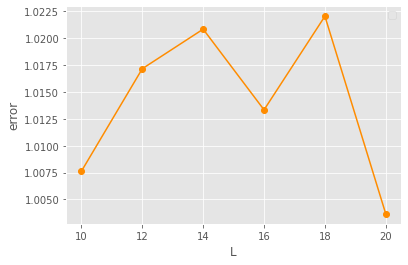

In [ ]:
if __name__ == '__main__':
    k = 24
    errors=[]
    query_indices = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    #query_indices = [100]
    for L in range(10,21,2):
        A = load_data('/content/Data/question 3_LSH/data/patches.csv')
        functions = create_functions(k=k,L=L)
        hashed_A = hash_data(functions,A)
        lsh_neighbors = []
        lsh_times = []
        linear_neighbors = []
        linear_times = []
        queries = []
        lsh_distances = []
        linear_distances = []
        

        # Need to run for all query indices to achieve an accurate error measure
        for query_index in query_indices:
            print('LSH Search on Index %i' % (query_index))
            start = default_timer()
            lsh_neighbor,lsh_dist = lsh_search(A,hashed_A,functions,query_index, num_neighbors=3)
            print(lsh_dist)
            print(lsh_neighbor)
            end = default_timer()
            lsh_times.append(end - start)

            print('Linear Search on Index %i' % (query_index))
            start = default_timer()
            linear_neighbor,linear_dist = linear_search(A, query_index, num_neighbors=3)
            print(linear_dist)
            print(linear_neighbor)
            end = default_timer()
            linear_times.append(end - start)

            lsh_neighbors.append(lsh_neighbor)
            linear_neighbors.append(linear_neighbor)
            lsh_distances.append(lsh_dist)
            linear_distances.append(linear_dist)
        

        print('Computing Error')
        error = lsh_error(lsh_distances, linear_distances)
        errors.append(error)
    print(errors)
    Ls = [i for i in range(10,21,2)]
    plt.plot(Ls, errors, '-o', color='darkorange')
    plt.xlabel('L')
    plt.ylabel('error')
    plt.legend(loc='best')
    plt.show()


LSH Search on Index 100
[24198.0]
[7551, 8196, 28351]
Linear Search on Index 100
[24198.0]
[7551, 8196, 28351]
LSH Search on Index 200
[27851.0]
[91, 604, 1888]
Linear Search on Index 200
[27851.0]
[91, 604, 1888]
LSH Search on Index 300
[29037.0]
[15818, 22057, 9006]
Linear Search on Index 300
[29037.0]
[15818, 22057, 9006]
LSH Search on Index 400
[27836.0]
[28676, 33010, 5875]
Linear Search on Index 400
[27836.0]
[28676, 33010, 5875]
LSH Search on Index 500
[9157.0]
[1178, 557, 35904]
Linear Search on Index 500
[9157.0]
[1178, 557, 35904]
LSH Search on Index 600
[11074.0]
[49309, 373, 44503]
Linear Search on Index 600
[11074.0]
[49309, 373, 44503]
LSH Search on Index 700
[26227.0]
[41352, 44006, 36422]
Linear Search on Index 700
[26227.0]
[41352, 44006, 36422]
LSH Search on Index 800
[15170.0]
[30478, 44743, 34353]
Linear Search on Index 800
[15170.0]
[30478, 44743, 34353]
LSH Search on Index 900
[27381.0]
[29023, 15184, 20405]
Linear Search on Index 900
[27381.0]
[29023, 15184, 2040

No handles with labels found to put in legend.


[61529.0]
[27042, 24630, 33514]
Computing Error
[24198.0]
[24198.0]
[27851.0]
[27851.0]
[29285.0]
[29037.0]
[27836.0]
[27836.0]
[9157.0]
[9157.0]
[11074.0]
[11074.0]
[26366.0]
[26227.0]
[15170.0]
[15170.0]
[27639.0]
[27381.0]
[74558.0]
[61529.0]
[1.0011555526662224, 1.0022765026414506, 1.0092233924682745, 1.0652186762135443, 1.0235017108478024]


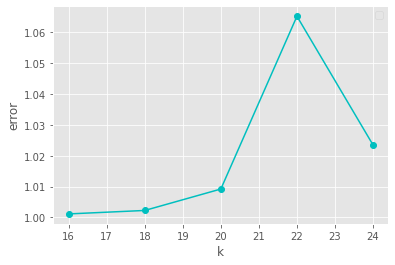

In [ ]:
if __name__ == '__main__':
    L = 10
    query_indices = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    # query_indices = [100]
    errors=[]
    for k in range(16,25,2):
        A = load_data('/content/Data/question 3_LSH/data/patches.csv')
        functions = create_functions(k=k,L=L)
        hashed_A = hash_data(functions,A)
        lsh_neighbors = []
        lsh_times = []
        linear_neighbors = []
        linear_times = []
        queries = []
        lsh_distances = []
        linear_distances = []
        

        # Need to run for all query indices to achieve an accurate error measure
        for query_index in query_indices:
            print('LSH Search on Index %i' % (query_index))
            start = default_timer()
            lsh_neighbor,lsh_dist = lsh_search(A,hashed_A,functions,query_index, num_neighbors=3)
            print(lsh_dist)
            print(lsh_neighbor)
            end = default_timer()
            lsh_times.append(end - start)

            print('Linear Search on Index %i' % (query_index))
            start = default_timer()
            linear_neighbor,linear_dist = linear_search(A, query_index, num_neighbors=3)
            print(linear_dist)
            print(linear_neighbor)
            end = default_timer()
            linear_times.append(end - start)

            lsh_neighbors.append(lsh_neighbor)
            linear_neighbors.append(linear_neighbor)
            lsh_distances.append(lsh_dist)
            linear_distances.append(linear_dist)
        

        print('Computing Error')
        error = lsh_error(lsh_distances, linear_distances)
        errors.append(error)
    print(errors)
    ks = [i for i in range(16,25,2)]
    plt.plot(ks, errors, '-o', color='c')
    plt.xlabel('k')
    plt.ylabel('error')
    plt.legend(loc='best')
    plt.show()